## Helper Notebook to Inspect  PNW ML Catalog




- All waveform data downloaded from [IRIS DMC](https://ds.iris.edu/ds/nodes/dmc/).
- Events and phase information are downloaded from [ANSS/ComCat](https://earthquake.usgs.gov/data/comcat/) using [libcomcat](https://github.com/usgs/libcomcat).

- Please download datasets manually from Goole Drive. See link below.
---
 ##### Yiyu Ni (niyiyu@uw.edu)
 ##### Earth and Space Sciences
 ##### University of Washington

In [1]:
# some modules are not intalled in google colab by default.
# !pip install obspy scipy

In [2]:
# ... suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import obspy
import pyasdf
import pandas as pd
import numpy as np

# ... plotting lib
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# ... datetime interaction
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime

# ... lib for comcat access
# ... If you work in Google Colab, I coundn't find a way to install libcomcat 
# ... through pip. Please skip this libcomcat part.
#
from libcomcat.dataframes import get_phase_dataframe
from libcomcat.search import get_event_by_id

# ... mount drive through google colab
# 
# from google.colab import drive
# drive.mount('/content/drive')

In [123]:
def interactive_plotting(df, index, seconds_before = 3, seconds_after = 3, sample_rate = 100, 
                         apply_filter = None, freq = None, freqmax = None, freqmin = None, client = None, fs = None):
    source_id = df.iloc[index]['source_id']
    net = df.iloc[index]['station_network_code']
    sta = df.iloc[index]['station_code']
    loc =  df.iloc[index]['station_location_code']
    cha = df.iloc[index]['trace_channel']
    trace_starttime = df.iloc[index]['trace_start_time']
    sta = df.iloc[index]['station_code']
    net = df.iloc[index]['station_network_code']
    otime = df.iloc[index]['source_origin_time']
    source_origin_time = UTCDateTime(otime)
    year = source_origin_time.year
    starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
    if fs:
        stream = fs[year].waveforms["%s_%s" % (net, sta)].prediction.trim(starttime = source_origin_time - 20, 
                                                      endtime = source_origin_time + 100, nearest_sample=False)
    elif client:
        stream = client.get_waveforms(net, sta, "", cha, UTCDateTime(trace_starttime), UTCDateTime(trace_starttime) + 200)
    else:
        print("Either local files or FDSN client must be specified.")
        return
    
    if apply_filter == 'bandpass':
        stream.filter(apply_filter, freqmin = freqmin, freqmax = freqmax)
    elif apply_filter is not None:
        stream.filter(apply_filter, freq = freq)
        
    data = np.array(stream)
    x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(data.shape[-1])]

    plt.figure(figsize = (12, 10), dpi = 80)
    plt.subplots_adjust(hspace = 0.2)
    plt.subplot(2, 1, 1)
    plt.title("%s.%s..%s" % (net, sta, cha), fontsize = 20)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    myFmt = mdates.DateFormatter('%X.%f\n%Y/%m/%d')
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.scatter([source_origin_time], [0], marker = '*', color = 'r', zorder = 90, label = "Origin Time")
    
    plt.subplot(2, 1, 2)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    myFmt = mdates.DateFormatter('%X.%f\n%Y/%m/%d')
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    plt.scatter([source_origin_time], [0], marker = '*', color = 'r', zorder = 90, label = "Origin Time")
        
    if pd.notnull(df.iloc[index]['trace_UW_P_arrival_time']):
        plt.subplot(2, 1, 1)
        p_time = [(starttime + dt(seconds = df.iloc[index]['trace_UW_P_arrival_time'] - trace_starttime)) for _ in range(10)]
        plt.plot(p_time, np.linspace(data.min(), data.max(), 10), 
             'r--', label = 'PNSN P Pick', linewidth = 2)
        plt.xlim([p_time[0] - dt(seconds = seconds_before),  
              p_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival
        plt.legend()

    if pd.notnull(df.iloc[index]['trace_UW_S_arrival_time']):
        plt.subplot(2, 1, 2)
        s_time = [(starttime + dt(seconds = df.iloc[index]['trace_UW_S_arrival_time'] - trace_starttime)) for _ in range(10)]
        plt.plot(s_time, np.linspace(data.min(), data.max(), 10), 
             'k--', label = 'PNSN S Pick', linewidth = 2)
        plt.xlim([s_time[0] - dt(seconds = seconds_before),  
              s_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival
        plt.legend()
        
    if pd.notnull(df.iloc[index]['trace_ML_P_arrival_time']):
        plt.subplot(2, 1, 1)
        p_time = [(starttime + dt(seconds = df.iloc[index]['trace_ML_P_arrival_time'] - trace_starttime)) for _ in range(10)]
        plt.plot(p_time, np.linspace(data.min(), data.max(), 10), 
             'r', label = 'ML P Pick', linewidth = 2)
        plt.xlim([p_time[0] - dt(seconds = seconds_before),  
              p_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival
        plt.legend()

    if pd.notnull(df.iloc[index]['trace_ML_S_arrival_time']):
        plt.subplot(2, 1, 2)
        s_time = [(starttime + dt(seconds = df.iloc[index]['trace_ML_S_arrival_time'] - trace_starttime)) for _ in range(10)]
        plt.plot(s_time, np.linspace(data.min(), data.max(), 10), 
             'k', label = 'ML S Pick', linewidth = 2)
        plt.xlim([s_time[0] - dt(seconds = seconds_before),  
              s_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival
        plt.legend()

## Load the PNW dataset
Please download the metadata from Google drive at:
- metadata (metadata.csv ~60MB): https://drive.google.com/file/d/1k1Qp9Anktg2fiZNZpXrilXh53egr-h4B/view?usp=sharing

A IRIS client will be specified to get waveform data. If you are using Google Colab, you can also access the data directly. See two options below.


In [4]:
# ... option 1 (use in a local machine): create an obspy IRIS client and download waveform
# client = obspy.clients.fdsn.Client("IRIS")    

# ... option 2 (use in Google Colab):
path_to_data = './From_EqT/'
fs = {}
for year in range(2000, 2021):
    fs[year] = pyasdf.ASDFDataSet(path_to_data + "waveforms_%d.hdf5" % year, mode = 'r')

# # be sure to check the location of waveforms and metadata

df = pd.read_csv(path_to_data + "metadata.csv")
df.insert(0, "index", range(len(df)))
df

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_magnitude,station_network_code,trace_channel,station_code,station_location_code,trace_sampling_rate_hz,trace_start_time,trace_UW_P_arrival_time,trace_UW_S_arrival_time,trace_ML_P_arrival_time,trace_ML_S_arrival_time
0,0,uw10518118,2000-12-31T18:07:44.830000Z,47.505667,-121.668667,2.90,UW,EHZ,NAC,NaN,NaN,9.782860e+08,9.782861e+08,NaN,9.782861e+08,NaN
1,1,uw10518118,2000-12-31T18:07:44.830000Z,47.505667,-121.668667,2.90,UW,EHZ,GHW,NaN,NaN,9.782860e+08,9.782861e+08,NaN,9.782861e+08,NaN
2,2,uw10518118,2000-12-31T18:07:44.830000Z,47.505667,-121.668667,2.90,UW,EHZ,BOW,NaN,NaN,9.782860e+08,9.782861e+08,NaN,NaN,9.782861e+08
3,3,uw10518118,2000-12-31T18:07:44.830000Z,47.505667,-121.668667,2.90,UW,EHZ,EPH,NaN,NaN,9.782860e+08,9.782861e+08,NaN,9.782861e+08,9.782861e+08
4,4,uw10518118,2000-12-31T18:07:44.830000Z,47.505667,-121.668667,2.90,UW,EHZ,GSM,NaN,NaN,9.782860e+08,9.782861e+08,NaN,9.782861e+08,9.782861e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425925,425925,uw61565537,2020-01-01T03:44:56.640000Z,46.848500,-121.757000,0.97,CC,BHZ,PANH,NaN,NaN,1.577850e+09,1.577850e+09,1.577850e+09,1.577850e+09,1.577850e+09
425926,425926,uw61565537,2020-01-01T03:44:56.640000Z,46.848500,-121.757000,0.97,UW,EHZ,LO2,NaN,NaN,1.577850e+09,1.577850e+09,NaN,1.577850e+09,1.577850e+09
425927,425927,uw61565537,2020-01-01T03:44:56.640000Z,46.848500,-121.757000,0.97,UW,HHN,LON,NaN,NaN,1.577850e+09,NaN,1.577850e+09,1.577850e+09,1.577850e+09
425928,425928,uw61565537,2020-01-01T03:44:56.640000Z,46.848500,-121.757000,0.97,CC,BHZ,PR05,NaN,NaN,1.577850e+09,1.577850e+09,1.577850e+09,1.577850e+09,1.577850e+09


## Do some stream selection only if necessary

In [109]:
df_filt = df

# df_filt = df_filt[df_filt['source_id'] == 'uw61631152']      # select a source id
# df_filt = df_filt[df_filt['source_magnitude'] >= 5]          # select filter out magnitude
df_filt = df_filt[df_filt['station_network_code'] == 'TA']   # select network code
df_filt = df_filt[df_filt['station_code'] == 'E04D']          # select station code

df_filt

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_magnitude,station_network_code,trace_channel,station_code,station_location_code,trace_sampling_rate_hz,trace_start_time,trace_UW_P_arrival_time,trace_UW_S_arrival_time,trace_ML_P_arrival_time,trace_ML_S_arrival_time
183877,183877,uw10809168,2010-11-26T04:28:51.820000Z,46.771833,-121.976000,2.00,TA,BHZ,E04D,NaN,NaN,1.290746e+09,1.290746e+09,NaN,1.290746e+09,1.290746e+09
184033,184033,uw10813048,2010-12-17T07:41:24.430000Z,47.733500,-122.205167,2.40,TA,BHZ,E04D,NaN,NaN,1.292572e+09,1.292572e+09,NaN,1.292572e+09,1.292572e+09
184245,184245,uw10809458,2010-10-28T21:34:03.070000Z,46.626667,-123.172167,2.20,TA,BHZ,E04D,NaN,NaN,1.288302e+09,1.288302e+09,NaN,1.288302e+09,NaN
184278,184278,uw10809338,2010-10-28T06:19:29.700000Z,47.615833,-122.679500,2.30,TA,BHZ,E04D,NaN,NaN,1.288247e+09,1.288247e+09,NaN,1.288247e+09,1.288247e+09
184332,184332,uw10809113,2010-10-27T01:15:10.730000Z,46.433667,-121.667167,2.40,TA,BHZ,E04D,NaN,NaN,1.288142e+09,1.288142e+09,NaN,1.288142e+09,1.288142e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337409,337409,uw61102937,2016-01-14T15:33:33.350000Z,46.502667,-122.309833,0.89,TA,BHN,E04D,NaN,NaN,1.452786e+09,1.452786e+09,1.452786e+09,NaN,1.452786e+09
337419,337419,uw61102932,2016-01-14T15:27:40.630000Z,46.513167,-122.309833,1.00,TA,BHE,E04D,NaN,NaN,1.452785e+09,NaN,1.452785e+09,1.452785e+09,1.452785e+09
337507,337507,uw61118811,2016-01-13T13:59:59.900000Z,46.148667,-122.184667,1.51,TA,BHZ,E04D,NaN,NaN,1.452694e+09,1.452694e+09,1.452694e+09,1.452694e+09,1.452694e+09
337623,337623,uw61117926,2016-01-10T08:24:57.110000Z,46.197167,-122.186500,0.86,TA,BHZ,E04D,NaN,NaN,1.452414e+09,1.452414e+09,1.452414e+09,1.452414e+09,1.452414e+09


## Specify an index by looking at the "index" column of filtered dataframe

In [6]:
# specify a index:
# index = 38082

# ... or randomly look at all data set:
index = np.random.randint(185307)

df.iloc[index]

index                                             7802
source_id                                   uw10508373
source_origin_time         2000-09-21T06:54:36.090000Z
source_latitude_deg                          46.848667
source_longitude_deg                           -121.76
source_magnitude                                   1.7
station_network_code                                UW
trace_channel                                      EHZ
station_code                                       RER
station_location_code                              NaN
trace_sampling_rate_hz                             NaN
trace_start_time                          969519256.09
trace_UW_P_arrival_time                   969519277.23
trace_UW_S_arrival_time                            NaN
trace_ML_P_arrival_time                 969519277.2548
trace_ML_S_arrival_time                            NaN
Name: 7802, dtype: object

## Interactive with streams
**Note that interactive plotting is not available at Google Colab**

<IPython.core.display.Javascript object>


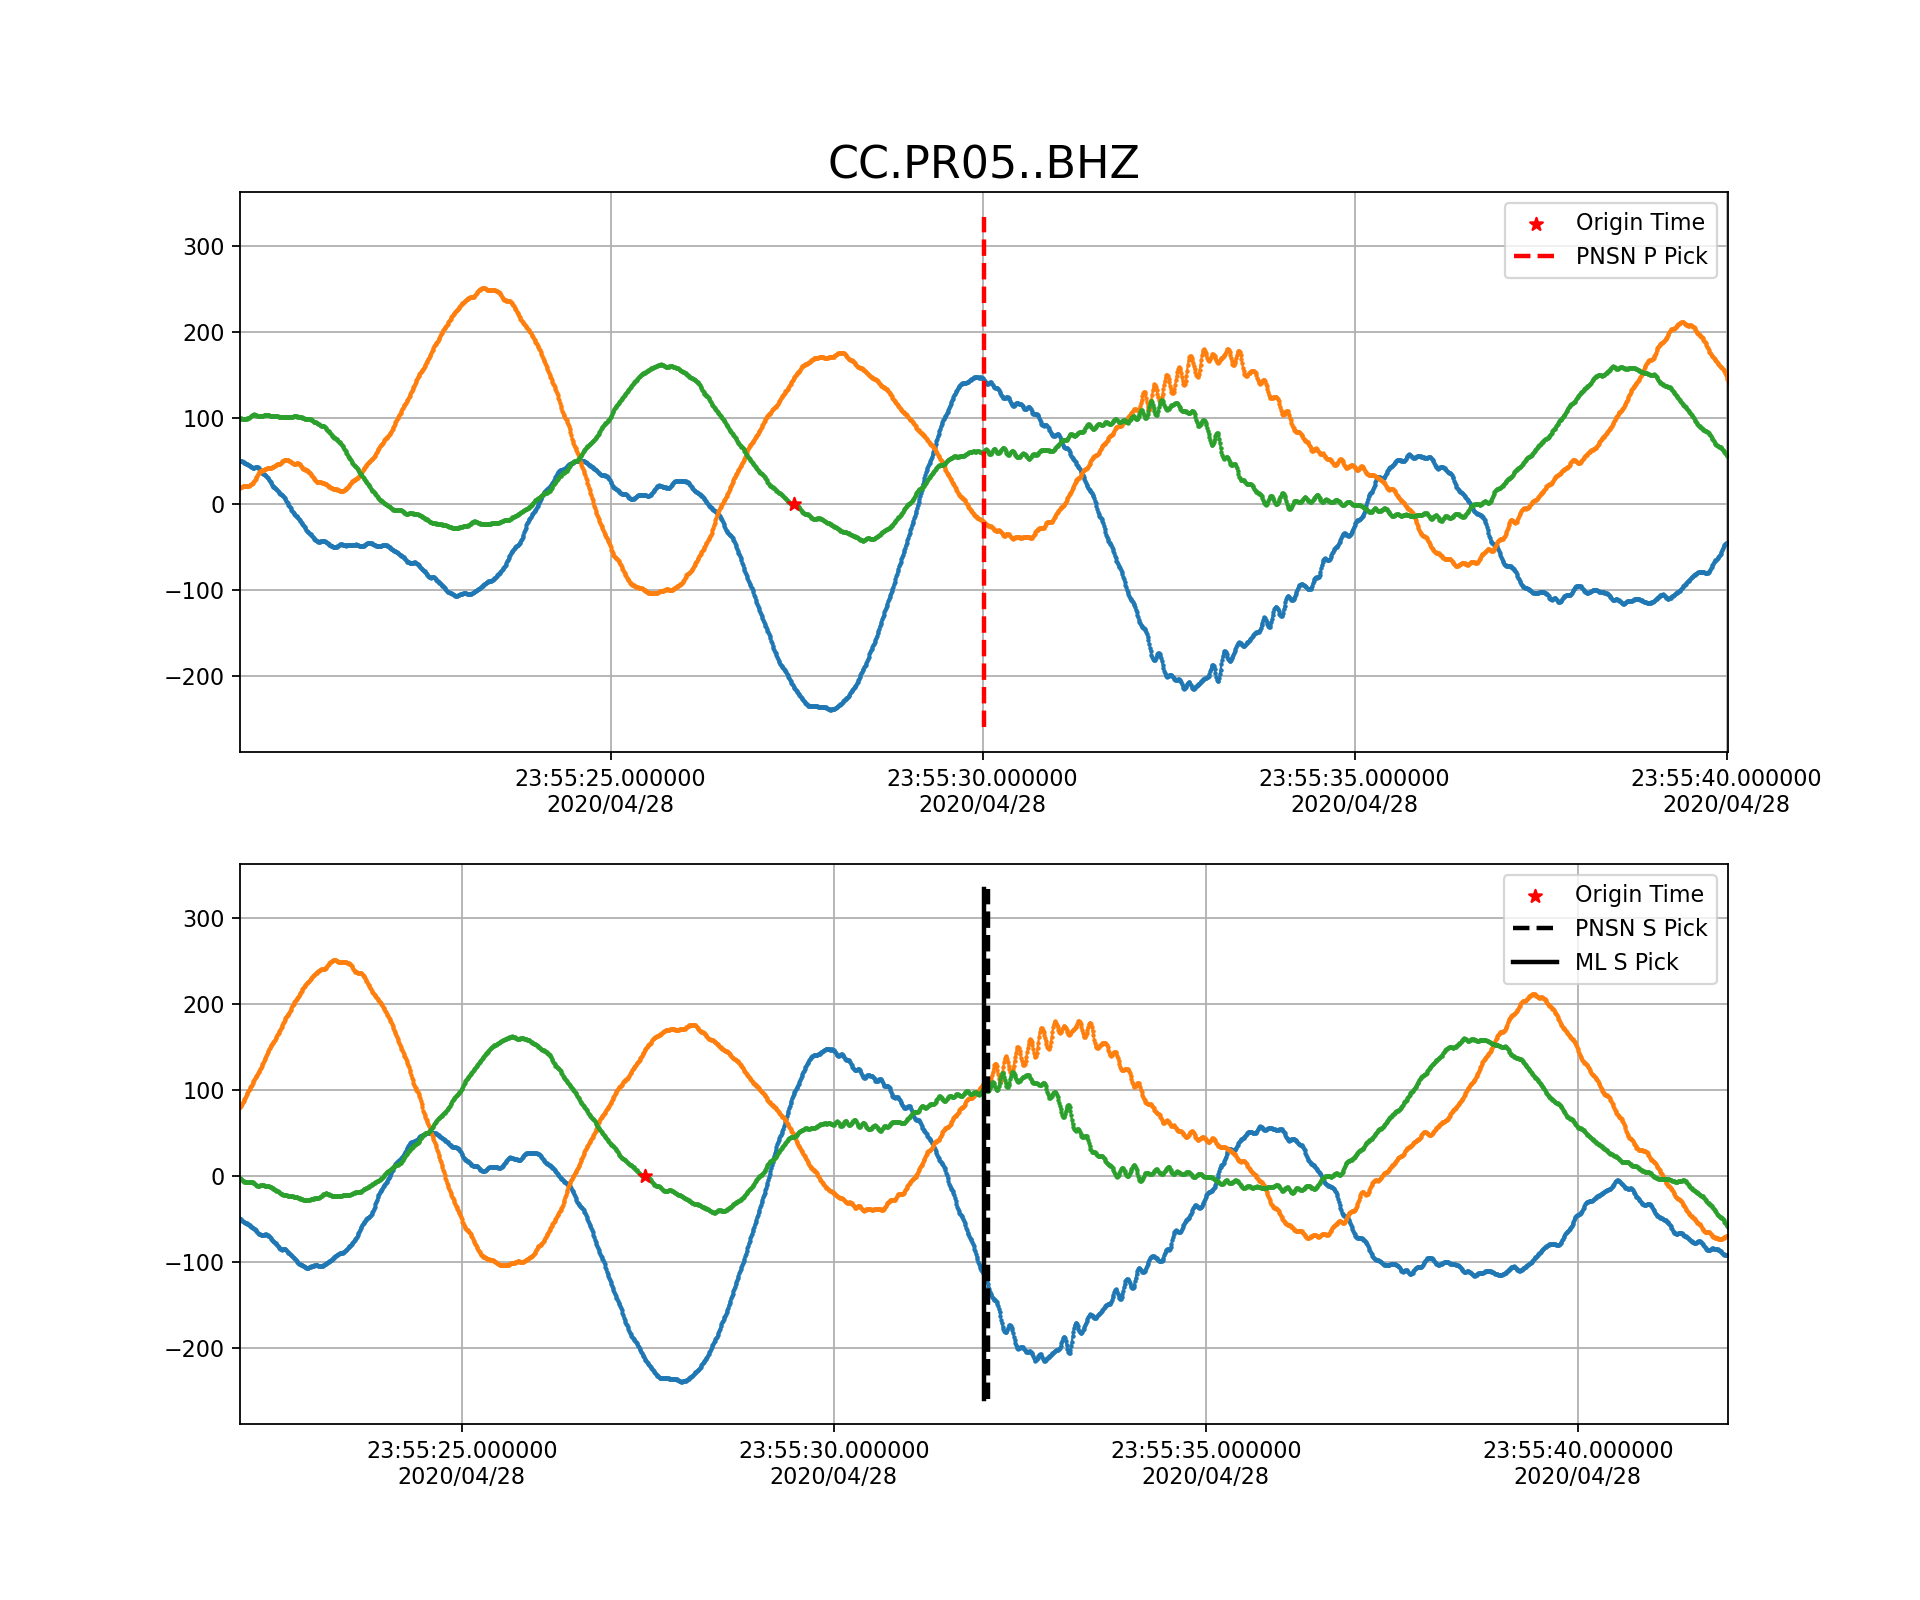

In [128]:
%matplotlib notebook

index = np.random.randint(425930)
# index = 213764

# ...pass the IRIS client (pretty fast)
# interactive_plotting(df, index, seconds_before = 10, seconds_after = 10,
#     apply_filter = 'bandpass',  freqmax = 10, freqmin = 5, client = client)
/
# ...or file handles
interactive_plotting(df, index, seconds_before = 10, seconds_after = 10,
    apply_filter = 'lowpass',  freq = 10, fs = fs)

## Use ComCat Python interface to check the arrivals from ANSS
**Note that libcomcat is not available at Google Colab**

In [221]:
source_id = df.iloc[index]['source_id']
detail = get_event_by_id(source_id, includesuperseded=False)
df_cc = get_phase_dataframe(detail, catalog='uw')
df_cc[df_cc['Channel'].str.contains(df.iloc[index]['station_code'])]

,Channel,Distance,Azimuth,Phase,Arrival Time,Status,Residual,Weight,Agency
70,UW.ELL.EHZ.,0.981,124.4,P,2000-07-31 03:13:08.840000,manual,0.13,1.0,UW
71,UW.ELL.EHZ.,0.981,124.4,S,2000-07-31 03:13:23.120000,manual,0.32,1.0,UW
